In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from skimage.io import imread
from skimage.transform import resize
from os.path import join
from glob import glob
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data import

In [3]:
# Load CSV file
gt = pd.read_csv('ground_truth.csv')
main_folder = 'tom_and_jerry'

# Functions

In [4]:
def get_labels(name):
    if 'tom_jerry_0' in name:
        return 0
    elif 'tom_jerry_1' in name:
        return 1
    elif 'tom' in name:
        return 2
    elif 'jerry' in name:
        return 3
    else:
        raise NotImplementedError('Not existing class!')

In [5]:
def prepare_data(images):
    X = []
    y = []

    for image in images:
        image_name = image.split('\\')[2]
        image_read = imread(image)
        resized_image = resize(image_read, (150, 150))
        flatten_image = resized_image.flatten()
        X.append(flatten_image)
        labels = np.array(gt.loc[gt['filename'] == image_name, ['tom', 'jerry']]).flatten()
        y.append(labels)

    return np.array(X), np.array(y)

In [6]:
def prepare_data2(images):
    X = []
    y = []

    for image in images:
        label = image.split('\\')[1]
        image_read = imread(image)
        resized_image = resize(image_read, (150, 150))
        flatten_image = resized_image.flatten()
        X.append(flatten_image)
        y.append(label)

    return np.array(X), np.array(y)

In [7]:
def prepare_data3(images):
    X = []
    y = []

    for image in images:
        
        # Get the label
        image_name = image.split('\\')[1]
        label = get_labels(image_name)

        # Load the image
        image = cv2.imread(images[0])

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        resized_image = resize(gray_image, (150, 150))

        # Calculate HOG
        feat = hog(resized_image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1))

        X.append(feat)
        y.append(label)

    return np.array(X), np.array(y)

In [8]:
def extract_features(images, feat_type, img_size):

    labels = []
    features = []

    for image in tqdm(images):

        image_name = image.split('\\')[1]
        label = get_labels(image_name)

        img = cv2.imread(image, 0)

        img = cv2.resize(img, (img_size, img_size))

        if feat_type == 'hog':
            feat = hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1))
        elif feat_type == 'lbp':
            feat = np.ravel(local_binary_pattern(img, P=100, R=5))
        elif feat_type == 'img':
            img = img / 256.0
            feat = np.ravel(img)
        else:
            raise NotImplementedError('Not implemented feature!')

        features.append(feat)
        labels.append(label)

    return features, labels

In [9]:
def class_percentage(dataset, title, class_colors={'tom': 'red', 'jerry': 'green', 'tom_jerry_0': 'dodgerblue', 'tom_jerry_1': 'gold'}):
    class_counts = {}
    total_images = len(dataset)
    
    for path in dataset:
        class_name = path.split('\\')[1] 
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    labels = class_counts.keys()
    sizes = [count / total_images * 100 for count in class_counts.values()]

    colors = [class_colors[class_name] for class_name in labels]

    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Data exploration & analysis

In [10]:
folders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']
for folder in folders:
    images = glob(join(main_folder, folder, '*.jpg'))
    print('Total amount of {}: {}'.format(folder, len(images)))

Total amount of jerry: 1240
Total amount of tom: 1930
Total amount of tom_jerry_0: 1528
Total amount of tom_jerry_1: 780


In [11]:
images = glob(join(main_folder, '*', '*.jpg'))
print('Total amount of images: {}'.format(len(images)))
print('List of images:', images)

Total amount of images: 5478
List of images: ['tom_and_jerry\\jerry\\frame100.jpg', 'tom_and_jerry\\jerry\\frame1032.jpg', 'tom_and_jerry\\jerry\\frame1033.jpg', 'tom_and_jerry\\jerry\\frame1034.jpg', 'tom_and_jerry\\jerry\\frame1035.jpg', 'tom_and_jerry\\jerry\\frame1036.jpg', 'tom_and_jerry\\jerry\\frame1037.jpg', 'tom_and_jerry\\jerry\\frame1038.jpg', 'tom_and_jerry\\jerry\\frame1039.jpg', 'tom_and_jerry\\jerry\\frame104.jpg', 'tom_and_jerry\\jerry\\frame1040.jpg', 'tom_and_jerry\\jerry\\frame1046.jpg', 'tom_and_jerry\\jerry\\frame105.jpg', 'tom_and_jerry\\jerry\\frame106.jpg', 'tom_and_jerry\\jerry\\frame1083.jpg', 'tom_and_jerry\\jerry\\frame1084.jpg', 'tom_and_jerry\\jerry\\frame1085.jpg', 'tom_and_jerry\\jerry\\frame1087.jpg', 'tom_and_jerry\\jerry\\frame1088.jpg', 'tom_and_jerry\\jerry\\frame1094.jpg', 'tom_and_jerry\\jerry\\frame1095.jpg', 'tom_and_jerry\\jerry\\frame1102.jpg', 'tom_and_jerry\\jerry\\frame1103.jpg', 'tom_and_jerry\\jerry\\frame1110.jpg', 'tom_and_jerry\\jerry\

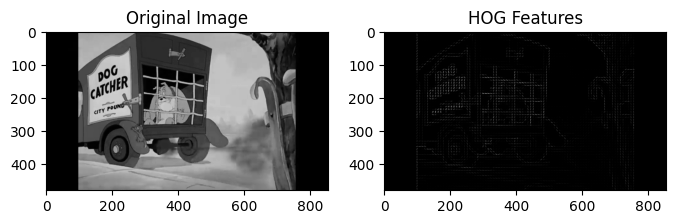

In [21]:
# Load the image
image = cv2.imread(images[0])

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#resized_image = resize(gray_image, (224, 224))

# Calculate HOG features
hog_features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

# Visualize the HOG image
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Features')
plt.show()

# Data preparation

In [13]:
print('Before shuffling: {}'.format(images[:10]))
np.random.shuffle(images)
print('After shuffling: {}'.format(images[:10]))

Before shuffling: ['tom_and_jerry\\jerry\\frame100.jpg', 'tom_and_jerry\\jerry\\frame1032.jpg', 'tom_and_jerry\\jerry\\frame1033.jpg', 'tom_and_jerry\\jerry\\frame1034.jpg', 'tom_and_jerry\\jerry\\frame1035.jpg', 'tom_and_jerry\\jerry\\frame1036.jpg', 'tom_and_jerry\\jerry\\frame1037.jpg', 'tom_and_jerry\\jerry\\frame1038.jpg', 'tom_and_jerry\\jerry\\frame1039.jpg', 'tom_and_jerry\\jerry\\frame104.jpg']
After shuffling: ['tom_and_jerry\\jerry\\frame1613.jpg', 'tom_and_jerry\\tom_jerry_1\\frame1547.jpg', 'tom_and_jerry\\tom\\frame211.jpg', 'tom_and_jerry\\tom_jerry_0\\frame3289.jpg', 'tom_and_jerry\\jerry\\frame1976.jpg', 'tom_and_jerry\\tom\\frame907.jpg', 'tom_and_jerry\\tom_jerry_1\\frame1578.jpg', 'tom_and_jerry\\tom\\frame3769.jpg', 'tom_and_jerry\\tom\\frame4229.jpg', 'tom_and_jerry\\tom_jerry_0\\frame3806.jpg']


In [14]:
trainset = images[:int(0.7*len(images))]
valset = images[int(0.7*len(images)):int(0.85*len(images))]
testset = images[int(0.85*len(images)):]
print('Total: {} splitted in Train: {}, Val: {} and Test: {}'.format(len(images), len(trainset), len(valset), len(testset)))

Total: 5478 splitted in Train: 3834, Val: 822 and Test: 822


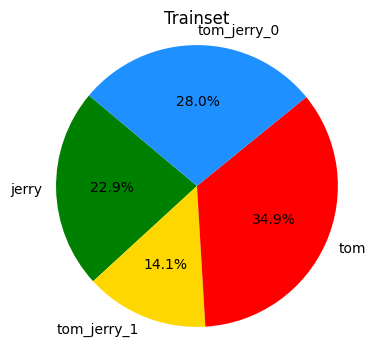

In [15]:
class_percentage(trainset, 'Trainset')

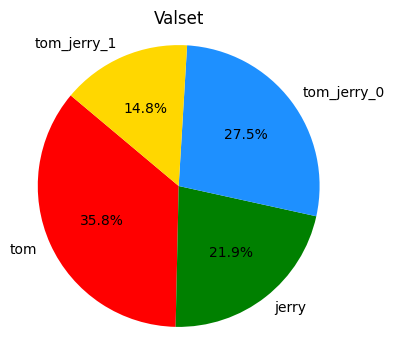

In [16]:
class_percentage(valset, 'Valset')

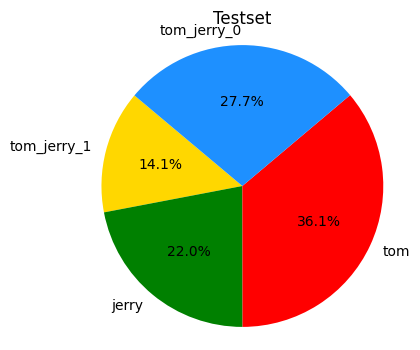

In [17]:
class_percentage(testset, 'Testset')

In [26]:
img_size = 120
feature_type = 'lbp'

train_x, train_y = extract_features(trainset, feature_type, img_size)
val_x, val_y = extract_features(valset, feature_type, img_size)
test_x, test_y = extract_features(testset, feature_type, img_size)
print('Train: {}, Val: {} and Test: {}'.format(len(train_x), len(val_x), len(test_x)))
print('Total: {}'.format(len(train_x) + len(val_x) + len(test_x)))

100%|██████████| 822/822 [00:33<00:00, 24.30it/s]

Train: 3834, Val: 822 and Test: 822
Total: 5478


In [ ]:
def plot_confusion_matrix_ml(model, val_x, val_y):
    predictions = model.predict(val_x)
    cm = confusion_matrix(val_y, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

# Modelling - Support Vector Classifier

### Training

In [27]:
clf = SVC(kernel='rbf', class_weight='balanced', decision_function_shape='ovo', random_state=42)
clf.fit(train_x, train_y)

SVC(class_weight='balanced', decision_function_shape='ovo', random_state=42)

### Validation

In [28]:
print('Validation accuracy SVC: {:.3f}'.format(clf.score(val_x, val_y)))

Validation accuracy SVC: 0.641


### Confusion matrix

In [ ]:
plot_confusion_matrix_ml(clf, val_x, val_y)

### Test

In [29]:
pred_y_test = clf.predict(test_x)
print('Predicted {} samples: {}'.format(len(pred_y_test), pred_y_test))
print('GT {} samples: {}'.format(len(test_y), test_y))

Predicted 822 samples: [1 3 0 2 2 2 2 2 0 1 2 0 2 1 2 2 0 2 2 0 2 2 0 1 0 3 0 2 1 2 2 2 2 3 0 0 2
 3 2 2 3 0 0 2 0 2 0 0 2 0 0 2 2 0 2 2 0 2 2 2 2 2 2 2 2 3 2 2 2 3 2 0 2 2
 1 3 0 2 0 2 2 2 2 3 2 0 0 2 2 2 2 3 0 2 3 0 2 1 2 3 0 0 2 2 3 1 2 2 0 2 2
 2 1 2 2 0 2 2 3 2 0 2 0 0 2 2 2 3 0 3 0 2 2 0 0 0 0 3 2 2 2 0 0 2 0 2 0 0
 3 0 2 0 2 1 2 2 2 1 0 3 0 3 3 2 3 0 0 0 2 2 1 0 2 0 2 0 3 2 3 3 2 1 3 2 2
 0 2 0 0 2 0 2 0 3 0 2 2 2 3 0 3 2 2 0 0 1 1 3 0 2 2 3 0 2 2 2 2 2 2 2 2 1
 2 2 1 3 2 0 2 0 2 0 2 2 2 2 2 2 2 1 0 2 3 2 0 0 3 2 3 3 2 0 3 3 2 0 2 2 3
 2 0 3 0 2 2 3 2 0 2 2 3 2 3 2 0 2 2 2 0 0 0 2 2 2 2 2 1 1 3 0 2 3 3 2 2 0
 2 2 3 2 2 2 1 2 0 2 2 2 0 3 0 2 3 0 0 2 0 2 2 1 2 2 2 2 0 3 0 2 0 1 0 2 2
 1 2 0 2 0 2 2 2 2 0 2 3 3 2 3 0 3 1 2 2 2 0 3 0 2 3 3 2 2 2 3 3 0 2 0 0 2
 0 3 3 2 2 2 0 2 2 0 1 2 2 0 0 2 2 0 0 1 2 0 0 0 0 2 2 0 0 3 0 3 2 1 0 2 0
 0 3 0 2 0 2 2 2 2 2 0 3 3 2 2 3 1 1 2 0 0 3 0 2 2 3 3 3 3 2 2 2 2 2 0 2 2
 3 2 2 0 3 2 1 0 0 3 2 0 2 2 0 0 2 2 3 2 2 0 0 3 2 0 2 2 0 1 2 0 2 2 3 3 1
 0

### Accuracy

In [30]:
print('Final Accuracy Decision Tree: {:.3f}'.format(accuracy_score(test_y, pred_y_test)))

Final Accuracy Decision Tree: 0.639


In [31]:
# Classification report
pred_y_train = clf.predict(train_x)
print('---------------TRAIN SET---------------')
print(classification_report(train_y, pred_y_train))
print('---------------TEST SET---------------')
print(classification_report(test_y, pred_y_test))

---------------TRAIN SET---------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1074
           1       1.00      1.00      1.00       542
           2       1.00      0.99      0.99      1339
           3       1.00      1.00      1.00       879

    accuracy                           1.00      3834
   macro avg       1.00      1.00      1.00      3834
weighted avg       1.00      1.00      1.00      3834

---------------TEST SET---------------
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       228
           1       0.91      0.42      0.58       116
           2       0.60      0.81      0.69       297
           3       0.78      0.56      0.65       181

    accuracy                           0.64       822
   macro avg       0.71      0.60      0.62       822
weighted avg       0.67      0.64      0.63       822



# Modelling - Decision Tree Classifier

### Training

In [32]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(train_x, train_y)

DecisionTreeClassifier(random_state=42)

### Validation

In [33]:
print('Validation accuracy Decision Tree: {:.3f}'.format(clf.score(val_x, val_y)))

Validation accuracy Decision Tree: 0.450


### Test

In [34]:
pred_y_test = clf.predict(test_x)
print('Predicted {} samples: {}'.format(len(pred_y_test), pred_y_test))
print('GT {} samples: {}'.format(len(test_y), test_y))

Predicted 822 samples: [1 3 2 1 2 1 1 2 3 3 1 3 3 1 3 3 0 0 0 2 2 1 0 3 1 3 3 2 0 3 3 2 2 0 2 2 0
 0 0 0 0 0 2 3 0 0 1 0 2 1 1 3 3 0 3 3 0 0 2 2 3 0 2 0 2 3 2 3 2 0 3 0 2 2
 3 0 3 0 1 0 3 0 0 0 1 1 0 1 2 2 1 3 0 2 3 0 0 0 2 3 2 3 0 3 3 0 3 2 3 2 2
 2 1 0 2 2 2 2 0 2 0 1 0 0 2 2 3 3 0 3 3 0 1 0 0 0 3 1 2 2 2 0 0 2 0 0 2 1
 0 0 2 0 2 2 0 3 2 0 3 3 0 3 2 1 3 0 1 1 2 1 0 0 2 1 2 2 3 2 2 3 0 2 3 3 0
 0 0 3 0 3 0 2 0 2 2 2 2 0 3 2 3 2 1 0 0 1 1 0 0 3 0 3 2 3 3 0 2 2 3 2 2 0
 2 3 1 3 0 0 0 2 2 0 3 2 2 2 3 2 0 3 3 1 3 3 3 0 3 0 2 2 3 0 1 3 2 2 1 0 3
 2 2 3 3 2 2 3 2 0 1 0 3 3 3 3 0 3 0 3 0 2 3 0 3 0 2 3 1 2 3 2 1 0 3 2 2 0
 2 1 3 3 3 1 0 2 1 1 2 2 1 1 2 3 3 0 1 3 0 2 2 2 2 1 2 0 2 0 2 0 0 1 1 0 3
 1 0 2 0 0 3 3 2 2 3 2 3 3 0 3 3 0 1 0 2 2 0 2 2 2 1 3 2 2 2 2 0 2 2 2 0 0
 1 3 3 0 0 0 3 2 3 0 3 2 2 3 0 0 0 2 0 1 3 2 1 2 3 2 2 0 0 0 0 0 0 1 0 3 3
 3 3 3 2 2 3 3 2 3 2 2 1 3 2 3 3 1 1 0 0 3 2 3 2 0 3 2 2 3 3 2 2 2 2 0 0 3
 3 3 2 0 3 3 3 0 0 1 2 3 3 3 0 0 0 0 3 2 2 1 2 2 3 3 3 2 0 0 2 0 2 2 3 3 1
 0

### Accuracy

In [35]:
print('Final Accuracy Decision Tree: {:.3f}'.format(accuracy_score(test_y, pred_y_test)))

Final Accuracy Decision Tree: 0.456


In [36]:
# Classification report
pred_y_train = clf.predict(train_x)
print('---------------TRAIN SET---------------')
print(classification_report(train_y, pred_y_train))
print('---------------TEST SET---------------')
print(classification_report(test_y, pred_y_test))

---------------TRAIN SET---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1074
           1       1.00      1.00      1.00       542
           2       1.00      1.00      1.00      1339
           3       1.00      1.00      1.00       879

    accuracy                           1.00      3834
   macro avg       1.00      1.00      1.00      3834
weighted avg       1.00      1.00      1.00      3834

---------------TEST SET---------------
              precision    recall  f1-score   support

           0       0.41      0.46      0.43       228
           1       0.43      0.37      0.40       116
           2       0.52      0.46      0.49       297
           3       0.44      0.50      0.47       181

    accuracy                           0.46       822
   macro avg       0.45      0.45      0.45       822
weighted avg       0.46      0.46      0.46       822



# Modelling - Random Forest Classifier

### Training

In [37]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)

RandomForestClassifier(n_jobs=-1, random_state=42)

### Validation

In [38]:
print('Validation accuracy RandomForest: {:.3f}'.format(clf.score(val_x, val_y)))

Validation accuracy RandomForest: 0.652


### Test

In [39]:
pred_y_test = clf.predict(test_x)
print('Predicted {} samples: {}'.format(len(pred_y_test), pred_y_test))
print('GT {} samples: {}'.format(len(test_y), test_y))

Predicted 822 samples: [1 3 0 2 2 2 2 2 0 1 2 0 2 2 2 2 0 2 2 0 2 2 0 1 1 3 2 2 0 3 2 2 2 3 2 2 2
 2 2 3 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 0 2 0 0 2 0 2 3 2 2 2 3 3 2 2 2
 1 3 0 2 2 0 2 2 2 3 2 0 0 2 2 2 2 3 2 2 3 2 2 1 2 2 2 3 2 2 3 1 2 2 2 2 2
 2 1 2 2 2 2 2 3 2 0 2 0 0 2 2 2 3 0 3 2 0 3 2 0 0 2 3 2 2 2 0 3 3 0 2 0 0
 2 2 0 0 2 1 3 2 0 2 0 3 0 3 3 2 2 2 2 3 2 2 1 0 0 2 2 2 3 2 3 2 2 1 3 2 2
 0 2 2 0 2 2 2 0 3 2 2 2 3 3 2 3 2 0 0 2 1 1 3 2 3 2 3 2 2 2 0 2 2 2 2 2 0
 2 2 2 3 0 0 2 2 2 2 0 0 2 2 2 2 2 1 2 2 3 0 0 3 3 2 3 3 2 0 0 3 2 0 2 2 3
 2 2 2 0 0 2 3 2 0 2 2 2 2 3 2 0 2 2 3 0 0 0 2 2 2 2 2 1 2 3 0 3 3 3 0 2 0
 2 2 3 2 0 0 1 3 2 0 2 2 0 2 0 2 3 0 2 2 0 2 2 3 0 2 2 2 0 3 1 2 0 1 2 0 3
 1 2 2 3 0 2 2 2 2 2 2 3 3 2 0 2 3 1 3 0 2 3 3 0 2 3 3 2 2 2 3 3 0 0 2 2 2
 2 3 3 0 2 2 2 2 3 0 1 3 2 0 2 2 2 2 0 1 2 0 2 2 2 2 2 0 0 3 0 3 2 1 2 0 0
 2 3 2 2 0 2 2 2 2 2 2 3 3 2 0 3 2 1 3 0 2 3 2 2 2 3 2 3 3 2 2 2 2 2 0 2 2
 3 2 2 0 3 2 1 2 3 3 2 2 2 3 0 0 2 2 3 2 2 2 0 2 2 2 2 2 0 1 2 0 2 2 2 3 1
 0

### Accuracy

In [40]:
print('Final Accuracy RandomForest: {:.3f}'.format(accuracy_score(test_y, pred_y_test)))

Final Accuracy RandomForest: 0.648


In [41]:
# Classification report
pred_y_train = clf.predict(train_x)
print('---------------TRAIN SET---------------')
print(classification_report(train_y, pred_y_train))
print('---------------TEST SET---------------')
print(classification_report(test_y, pred_y_test))

---------------TRAIN SET---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1074
           1       1.00      1.00      1.00       542
           2       1.00      1.00      1.00      1339
           3       1.00      1.00      1.00       879

    accuracy                           1.00      3834
   macro avg       1.00      1.00      1.00      3834
weighted avg       1.00      1.00      1.00      3834

---------------TEST SET---------------
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       228
           1       0.93      0.35      0.51       116
           2       0.58      0.89      0.70       297
           3       0.76      0.59      0.66       181

    accuracy                           0.65       822
   macro avg       0.74      0.59      0.62       822
weighted avg       0.69      0.65      0.64       822

